In [51]:
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.models import Model
from keras.utils import multi_gpu_model, to_categorical
from keras.optimizers import SGD, Adam
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [48]:
train = pd.read_csv('train.csv')
train.isnull().sum()/len(train)*100
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [49]:
df = train
meanAge = int(df.Age.mean())
df.Age = df.Age.fillna(meanAge)
df = df.drop(['Cabin', 'Embarked', 'Ticket', 'Name', 'PassengerId', 'Fare'], axis=1)
df.Sex = df.Sex.map({'female': 1, 'male': 0})
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,0,22.0,1,0
1,1,1,1,38.0,1,0
2,1,3,1,26.0,0,0
3,1,1,1,35.0,1,0
4,0,3,0,35.0,0,0


In [50]:
df.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch
Survived,1.000000,-0.338481,0.543351,-0.067814,-0.035322,0.081629
Pclass,-0.338481,1.000000,-0.131900,-0.334974,0.083081,0.018443
Sex,0.543351,-0.131900,1.000000,-0.082949,0.114631,0.245489
Age,-0.067814,-0.334974,-0.082949,1.000000,-0.232978,-0.176486
SibSp,-0.035322,0.083081,0.114631,-0.232978,1.000000,0.414838
Parch,0.081629,0.018443,0.245489,-0.176486,0.414838,1.000000


In [58]:
Y_train = np.array(df.Survived).reshape((-1, 1))
Y_train[:10]
df = df.drop('Survived', axis=1)

In [61]:
randforestregressor = RandomForestRegressor(max_depth=10, random_state=1, verbose=1)
df = pd.get_dummies(df)
randforestregressor.fit(df, train.Survived)

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=1, warm_start=False)

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/
Code for RandomForestRegressor was taken from here as well as ideas for feature selection and dimensionality reduction techniques.

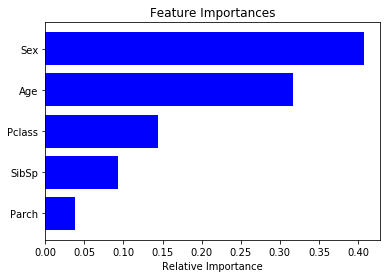

In [63]:
#look at feature importance
features = df.columns
importances = randforestregressor.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [64]:
def buildModel():
    # NEED TO EXPERIMENT WITH MODEL ARCHITECTURES
    # FIRST TEST IS NUMBER OF DENSE LAYERS FROM 0 - 3
    num_models = 4
    model = [0] * num_models
    
    for i in range(num_models):
        inputs = Input(shape=(5,))
        
        X = inputs
        
        for j in range(i):
            X = Dense(8, activation='relu', kernel_regularizer='l2')(X)
        
        outputs = Dense(1, activation='sigmoid', kernel_regularizer='l2')(X)
        
        model[i] = multi_gpu_model(Model(inputs=inputs, outputs=outputs), gpus=2) #initialise model with 2 GPUs
        model[i].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [69]:
model = buildModel()
model[0].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 5)            0                                            
__________________________________________________________________________________________________
lambda_33 (Lambda)              (None, 5)            0           input_17[0][0]                   
__________________________________________________________________________________________________
lambda_34 (Lambda)              (None, 5)            0           input_17[0][0]                   
__________________________________________________________________________________________________
model_33 (Model)                (None, 1)            6           lambda_33[0][0]                  
                                                                 lambda_34[0][0]                  
__________